In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import CM4Xutils
import xarray as xr

In [3]:
moc_metrics_dict = {
    e: xr.open_dataset(f"../data/processed/moc_metrics_{e}.nc")
    for e in ["piControl", "ssp585"]
}
moc_metrics_control = moc_metrics_dict["piControl"]

/vftmp/Henri.Drake/pid225583/ipykernel_3728959/3530473916.py:56: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(pcm, cax=cax)


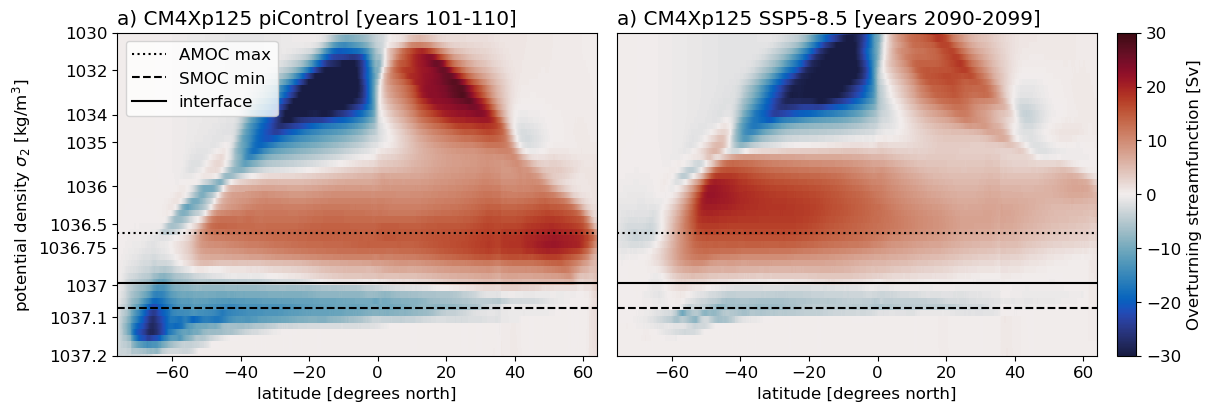

In [4]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

import numpy as np
import cmocean as cm

rho0 = 1035.

fig = plt.figure(figsize=(12, 4), constrained_layout=True)
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.04], wspace=0.05)

axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]
cax   = fig.add_subplot(gs[0, 2])  # dedicated colorbar axis on the right

pcm = None
for i, (e, moc_metrics) in enumerate(moc_metrics_dict.items()):
    ax = axes[i]

    # coordinates and plotting values
    lat = moc_metrics["geolat_v"]
    rho2_indices = np.arange(moc_metrics.rho2_i.size)

    pcm = ax.pcolor(
        lat,
        rho2_indices,
        moc_metrics.moc_timemean * 1e-6 / rho0, # convert from kg/s to Sv
        vmin=-30, vmax=30,
        cmap=cm.cm.balance
    )

    # density tick labels
    levels = [1030, 1032, 1034, 1035, 1036, 1036.5, 1036.75, 1037, 1037.1, 1037.2]
    lev_indices = np.interp(levels, moc_metrics.rho2_i, rho2_indices)
    ax.set_ylim(lev_indices[-1], lev_indices[0])
    if i == 0:
        ax.set_yticks(lev_indices)
        ax.set_yticklabels(levels)
        ax.set_ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]")
    else:
        ax.set_yticks([])

    # reference lines
    lev_idx_amoc = np.interp(moc_metrics_control.rho2_i_amoc, moc_metrics.rho2_i, rho2_indices)
    ax.axhline(lev_idx_amoc, label="AMOC max", color="k", linestyle=":")
    lev_idx_smoc = np.interp(moc_metrics_control.rho2_i_smoc, moc_metrics.rho2_i, rho2_indices)
    ax.axhline(lev_idx_smoc, label="SMOC min", color="k", linestyle="--")
    lev_idx_interface = np.interp(moc_metrics_control.rho2_i_interface, moc_metrics.rho2_i, rho2_indices)
    ax.axhline(lev_idx_interface, label="interface", color="k", linestyle="-")

    ax.set_xlim(-76, 64)
    ax.set_xlabel("latitude [degrees north]")
    if e == "piControl":
        ax.legend(loc="upper left")

# one shared colorbar to the right
cbar = fig.colorbar(pcm, cax=cax)
cbar.set_label("Overturning streamfunction [Sv]")

axes[0].set_title("a) CM4Xp125 piControl [years 101-110]", loc="left")
axes[1].set_title("a) CM4Xp125 SSP5-8.5 [years 2090-2099]", loc="left")
plt.savefig("../figures/moc_and_isopycnals.png", bbox_inches="tight", dpi=300)
plt.show()

In [5]:
for moc_metrics in moc_metrics_dict.values():
    moc_metrics.close()